<a href="https://colab.research.google.com/github/alok-108/suspicious-activity-detection-through-/blob/main/Human_Activity_Detection_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Unzip Dataset

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Cm84ydEgVpt8CGVuZvMvqTt7iXi7k3lq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Cm84ydEgVpt8CGVuZvMvqTt7iXi7k3lq" -O Dataset.zip && rm -rf /tmp/cookies.txt

--2025-05-19 23:55:05--  https://docs.google.com/uc?export=download&confirm=&id=1Cm84ydEgVpt8CGVuZvMvqTt7iXi7k3lq
Resolving docs.google.com (docs.google.com)... 74.125.195.113, 74.125.195.102, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Cm84ydEgVpt8CGVuZvMvqTt7iXi7k3lq&export=download [following]
--2025-05-19 23:55:05--  https://drive.usercontent.google.com/download?id=1Cm84ydEgVpt8CGVuZvMvqTt7iXi7k3lq&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c0c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-05-19 23:55:06 ERROR 404: Not Found.



In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Dataset.zip or
        Dataset.zip.zip, and cannot find Dataset.zip.ZIP, period.


# Import Required Libraries

In [ ]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 16.2 MB/s 


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3014656/45929032 bytes (6.6%)6258688/45929032 bytes (13.6%)9347072/45929032 bytes (20.4%)12632064/45929032 bytes (27.5%)16072704/45929032 bytes (35.0%)19488768/45929032 bytes (42.4%)22863872/45929032 bytes (49.8%)26312704/45929032 bytes (57.3%)29835264/45929032 bytes (65.0%)33218560/45929032 bytes (72.3%)36544512/45929032 bytes (79.6%)39845888/45929032 bytes (86.8%)

# Select Randomness

In [ ]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# View the dataset

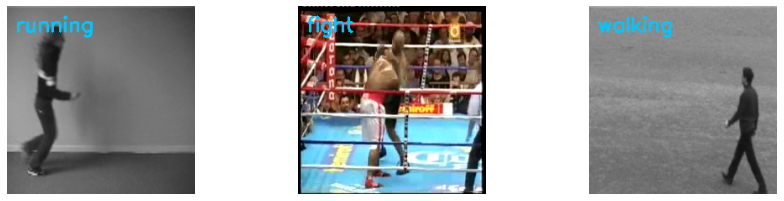

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('Dataset')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
# random_range = random.sample(range(len(all_classes_names)), len(all_classes_names))

# Iterating through all the generated random values.
for counter, random_index in enumerate(range(len(all_classes_names)), 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


# Set Dataset Variables

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "Dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["walking", "fight", "running"]

# Data pre-processing

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: walking
Extracting Data of Class: fight
Extracting Data of Class: running


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# Model Creation VGG-16 with LSTM

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed

video = Input(shape=(SEQUENCE_LENGTH,
                     IMAGE_HEIGHT,
                     IMAGE_WIDTH,
                     3))

# Base CNN layer of VGG-16 Model removing the Flatten Layer and 2 dense Layers
cnn_base = VGG16(input_shape=(IMAGE_HEIGHT,
                              IMAGE_WIDTH,
                              3),
                 weights="imagenet",
                 include_top=False)

# A 2D Pooling layer
cnn_out = GlobalAveragePooling2D()(cnn_base.output)

# VGG-16 with 2D Pooling Layer
cnn = Model(cnn_base.input, cnn_out)
cnn.trainable = False

# TimeDistributed The Input Video in Frames
encoded_frames = TimeDistributed(cnn)(video)

#Added LSTM Layer for the sequence of Frames
encoded_sequence = LSTM(256)(encoded_frames)

# Added Dense Layer
hidden_layer = Dense(1024, activation="relu")(encoded_sequence)

# Output Layer to predict Class
outputs = Dense(len(CLASSES_LIST), activation="softmax")(hidden_layer)

# Final Model
model = Model([video], outputs)

model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=["accuracy"])

58900480/58889256 [==============================] - 1s 0us/step


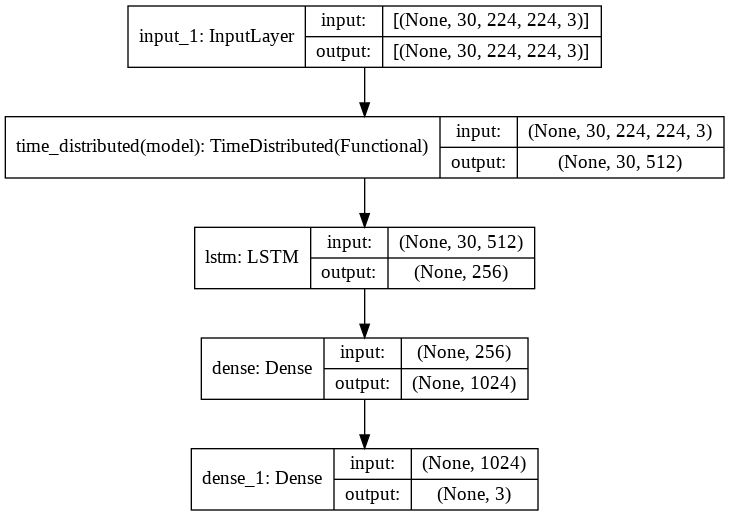

In [ ]:
plot_model(model, to_file = 'Suspicious_Human_Activity_Model.png', show_shapes = True, show_layer_names = True)

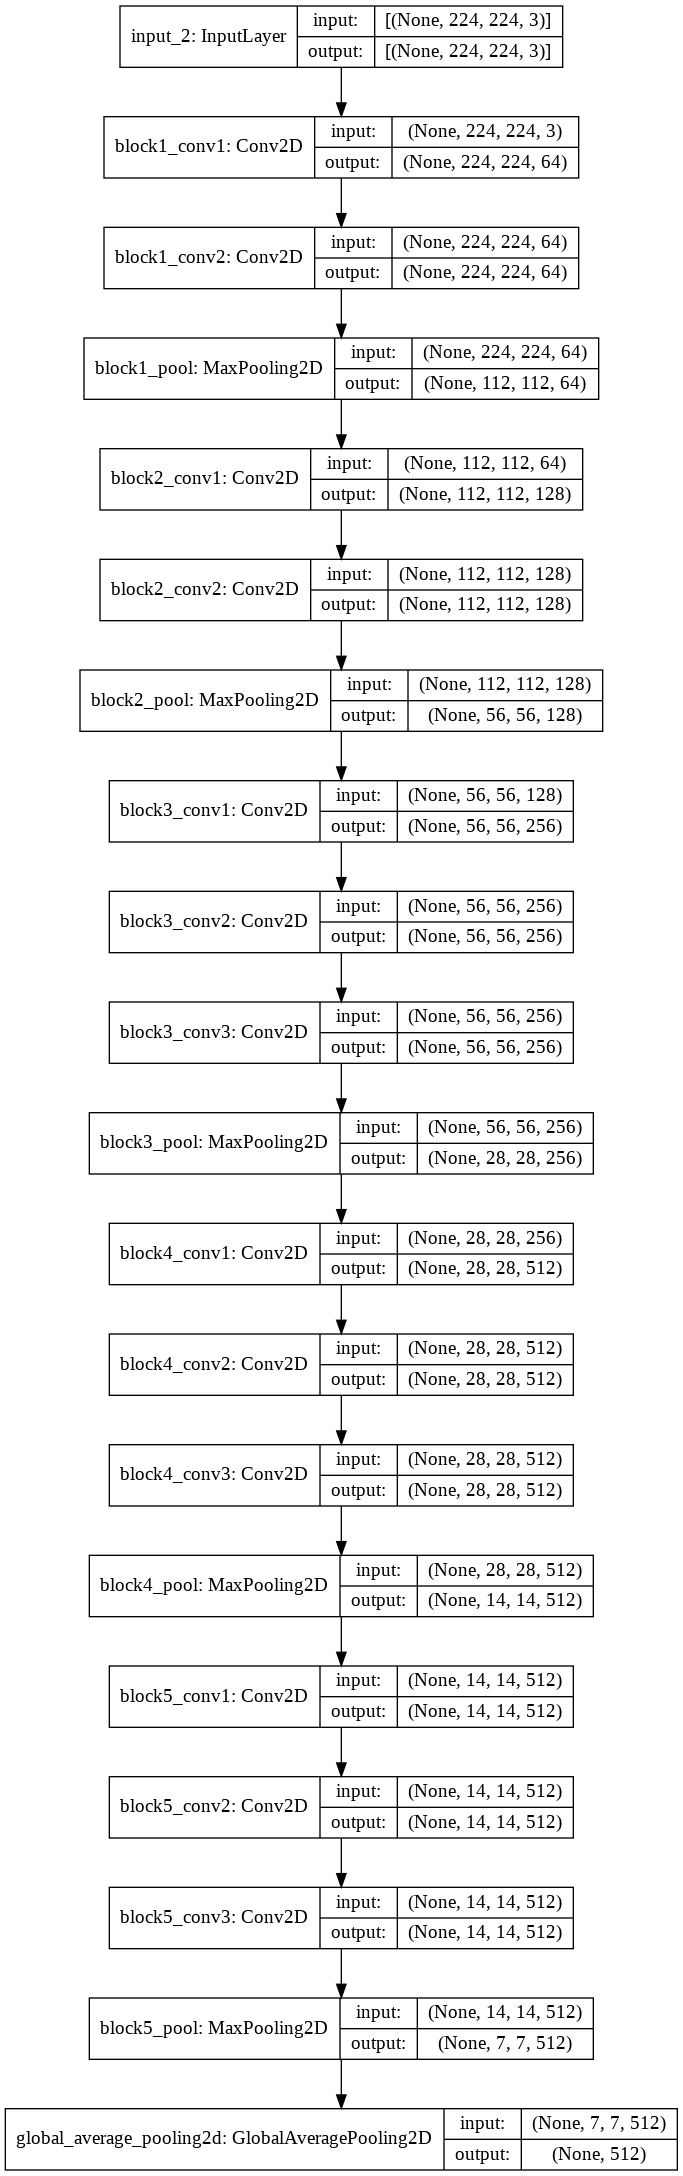

In [ ]:
plot_model(cnn, to_file = 'Suspicious_Human_Activity_VGG16_Model.png', show_shapes = True, show_layer_names = True)

# Model Training

In [ ]:
# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4, validation_split = 0.25)

Epoch 1/10
19/19 [==============================] - 123s 3s/step - loss: 0.9427 - accuracy: 0.5333 - val_loss: 0.6677 - val_accuracy: 0.6154
Epoch 2/10
19/19 [==============================] - 23s 1s/step - loss: 1.2489 - accuracy: 0.5733 - val_loss: 0.7531 - val_accuracy: 0.6154
Epoch 3/10
19/19 [==============================] - 23s 1s/step - loss: 0.6564 - accuracy: 0.6933 - val_loss: 0.4485 - val_accuracy: 0.7308
Epoch 4/10
19/19 [==============================] - 23s 1s/step - loss: 0.4901 - accuracy: 0.6800 - val_loss: 0.4368 - val_accuracy: 0.6538
Epoch 5/10
19/19 [==============================] - 23s 1s/step - loss: 0.4797 - accuracy: 0.7067 - val_loss: 0.4093 - val_accuracy: 0.7692
Epoch 6/10
19/19 [==============================] - 23s 1s/step - loss: 0.4688 - accuracy: 0.7200 - val_loss: 0.4395 - val_accuracy: 0.6538
Epoch 7/10
19/19 [==============================] - 23s 1s/step - loss: 0.4558 - accuracy: 0.7467 - val_loss: 0.4414 - val_accuracy: 0.6538
Epoch 8/10
19/19 [=

# Save Model

In [ ]:
# Save your Model.
model.save("Suspicious_Human_Activity_Detection_VGG16_LSTM_Model.h5")

# Plot Loss and Accuracy Graphs while Training

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

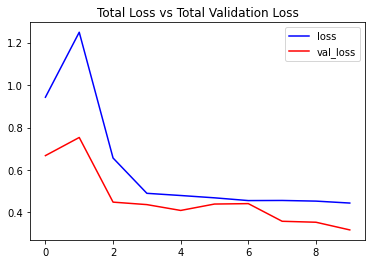

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

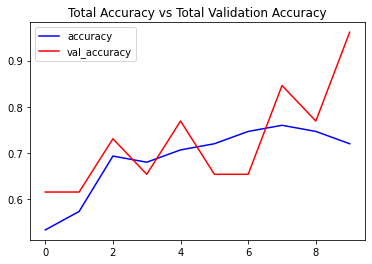

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Accuracy on Test Dataset

In [ ]:
# Calculate Accuracy On Test Dataset
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

Accuracy = 85.29411764705883
